Clases que he tenido que ir importando

In [ ]:
import torch
from torchvision import (
    datasets,
    transforms,
    models
)
from torch.utils.data import (
    DataLoader,
    random_split
)
import kagglehub
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
from torch import (
    nn,
    optim
)
import torch.nn.functional as F
from google.colab import drive
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
import seaborn as sns

Semilla

In [ ]:
def seed_everything(seed):
    import random
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)

seed_everything(42)

Función para entrenar la red

In [ ]:
def train_with_validation(model, train_loader, dev_loader, criterion, optimizer, epochs=5, name="Modelo"):
    """
    Entrena el modelo y valida en cada época.
    Adaptada para CrossEntropyLoss (sin one-hot encoding).
    """
    print(f"\n--- Entrenando: {name} ---")

    model.to(DEVICE)

    history = {
        'train_loss': [],
        'train_acc': [],
        'dev_loss': [],
        'dev_acc': [],
    }

    for epoch in range(epochs):
        # --- ENTRENAMIENTO ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad() # para que no se acumulen los gradientes
            outputs = model(inputs) # obtener las predicciones del modelo


            loss = criterion(outputs, labels) # Calcular la pérdida entre las predicciones y las etiquetas reales.

            loss.backward() # calcular los gradientes de la pérdida.
            optimizer.step() #Ajustar los pesos del modelo usando los gradientes y el optimizador.

            running_loss += loss.item() # Acumular la pérdida actual para monitorear el progreso

            # Accuracy en train
            _, predicted = torch.max(outputs, 1) # Obtener la clase con la mayor probabilidad (el índice máximo).
            total += labels.size(0) # Aumentar el contador total de muestras procesadas en la época.
            correct += (predicted == labels).sum().item() # Contar cuántas predicciones coinciden con las etiquetas reales.

        avg_train_loss = running_loss / len(train_loader) # Calcular la pérdida promedio de la época dividiendo la pérdida acumulada entre el número de lotes.
        train_acc = 100.0 * correct / total # Calcular la precisión final de la época (porcentaje de aciertos).

        # --- VALIDACIÓN ---
        model.eval()
        dev_running_loss = 0.0
        dev_correct = 0
        dev_total = 0

        with torch.no_grad(): # Desactiva el cálculo de gradientes; esencial solo para evaluación. Porque ya no aprende y ya no queremos actualizar los pesos
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs) # obtener las predicciones del modelo

                # Loss validación
                loss = criterion(outputs, labels)
                dev_running_loss += loss.item()

                # Accuracy validación
                _, predicted = torch.max(outputs, 1)
                dev_total += labels.size(0)
                dev_correct += (predicted == labels).sum().item()

        avg_dev_loss = dev_running_loss / len(dev_loader)
        dev_acc = 100.0 * dev_correct / dev_total

        # Guardar histórico
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        print(f'[Epoch {epoch + 1}/{epochs}] '
              f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {avg_dev_loss:.4f} | Val Acc: {dev_acc:.2f}%')

    return model, history

Función para gráfico

In [ ]:
def plot_training_history(history):
    """
    Dibuja las curvas de loss y accuracy (train y dev) guardadas en el diccionario 'history'.
    Espera claves: 'train_loss', 'train_acc', 'dev_loss', 'dev_acc'.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Loss ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['dev_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # --- Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['dev_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Función matriz de confusion

In [ ]:
def plot_confusion_matrix(model, loader, class_names, device):
  model.eval()
  all_preds = []
  all_labels = []
  classes = class_names
  with torch.no_grad():
      for inputs, labels in loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  print("\n--- Reporte de Clasificación ---")
  print(classification_report(all_labels, all_preds, target_names=classes))

Descarga Dataset

In [ ]:
# Descargar dataset desde KaggleHub
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

file_path = kagglehub.dataset_download("kmkarakaya/logos-bk-kfc-mcdonald-starbucks-subway-none")


# Rutas del dataset

train_data_dir = f"{file_path}/logos3/train"
test_data_dir = f"{file_path}/logos3/test"


# Transformaciones de las imágenes

transform = transforms.Compose([
    transforms.Resize((64, 64)), # Deben tener todas un tamaño fijo y este es un estandar para que conserve la imagen y sea rapido de entrenar
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizar la distribucion de los valores de los pixeles con la media y desviacion estandar para que sea mas eficiente
])


# Cargar datasets

train_dataset_full = datasets.ImageFolder(root=train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)


# Dividir train en train/validation (80/20) con semilla fija

train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])


# Crear DataLoaders

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Información general
class_names = test_dataset.classes
num_classes = len(class_names)
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de validación: {len(val_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")
print(f"Clases: {test_dataset.classes}")
print(f"Ejemplo - dimensión de una imagen: {train_dataset_full[0][0].shape}")

100%|██████████| 65.0M/65.0M [00:00<00:00, 112MB/s]

Extracting files...


Tamaño del conjunto de entrenamiento: 1390
Tamaño del conjunto de validación: 348
Tamaño del conjunto de prueba: 560
Clases: ['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']
Ejemplo - dimensión de una imagen: torch.Size([3, 64, 64])


Definicion arquitecturas

In [ ]:
# === ARQUITECTURA BASE ===
class BaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaseCNN, self).__init__()
        # Input: 64x64
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # -> 32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Pool -> 16x16
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Pool -> 8x8

        self.flatten_size = 64 * 8 * 8
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, self.flatten_size) # Aplanar
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# === ARQUITECTURA CON DROPOUT ===
class DropoutCNN(BaseCNN):
    def __init__(self, num_classes):
        super(DropoutCNN, self).__init__(num_classes)
        self.dropout = nn.Dropout(0.5) # 50% de probabilidad

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, self.flatten_size)
        x = self.relu(self.fc1(x))
        x = self.dropout(x) # <--- Dropout antes de la capa final
        x = self.fc2(x)
        return x

# === ARQUITECTURA MÁS PROFUNDA (4 Capas) ===
class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        # Nota: Al añadir capas, el tamaño final cambia.
        # Para simplificar, usamos un AdaptiveAvgPool que fuerza el tamaño a 1x1 antes de linear
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.relu(self.conv4(x)) # Sin pool aquí
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Ejecutar Experimentos


--- Entrenando: 1. Base CNN ---
[Epoch 1/15] Train Loss: 1.2203 | Train Acc: 54.82% | Val Loss: 0.8512 | Val Acc: 66.09%
[Epoch 2/15] Train Loss: 0.7428 | Train Acc: 72.66% | Val Loss: 0.8080 | Val Acc: 68.68%
[Epoch 3/15] Train Loss: 0.5840 | Train Acc: 79.50% | Val Loss: 0.5479 | Val Acc: 82.18%
[Epoch 4/15] Train Loss: 0.4337 | Train Acc: 84.60% | Val Loss: 0.4603 | Val Acc: 85.63%
[Epoch 5/15] Train Loss: 0.3098 | Train Acc: 89.14% | Val Loss: 0.4367 | Val Acc: 85.34%
[Epoch 6/15] Train Loss: 0.2428 | Train Acc: 91.94% | Val Loss: 0.4685 | Val Acc: 85.63%
[Epoch 7/15] Train Loss: 0.1633 | Train Acc: 94.82% | Val Loss: 0.4036 | Val Acc: 86.78%
[Epoch 8/15] Train Loss: 0.1144 | Train Acc: 95.97% | Val Loss: 0.5236 | Val Acc: 84.20%
[Epoch 9/15] Train Loss: 0.0996 | Train Acc: 96.98% | Val Loss: 0.3933 | Val Acc: 89.08%
[Epoch 10/15] Train Loss: 0.0766 | Train Acc: 97.27% | Val Loss: 0.4009 | Val Acc: 89.66%
[Epoch 11/15] Train Loss: 0.0566 | Train Acc: 98.63% | Val Loss: 0.4131 | Va

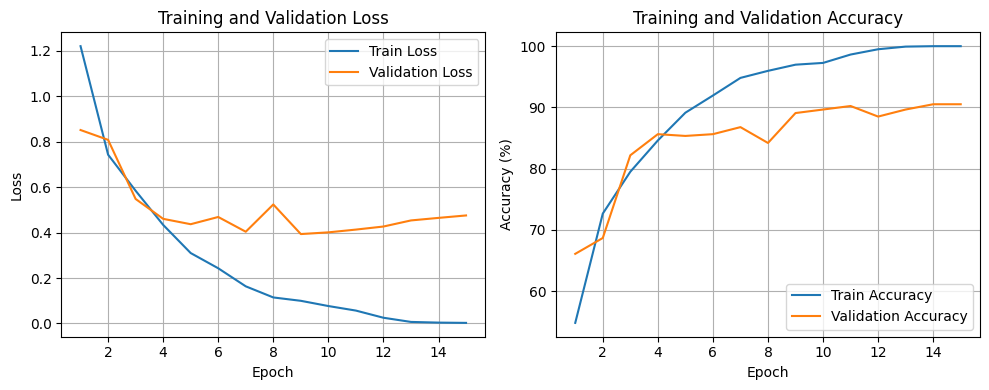

>> Matriz de Confusión (Modelo 1):


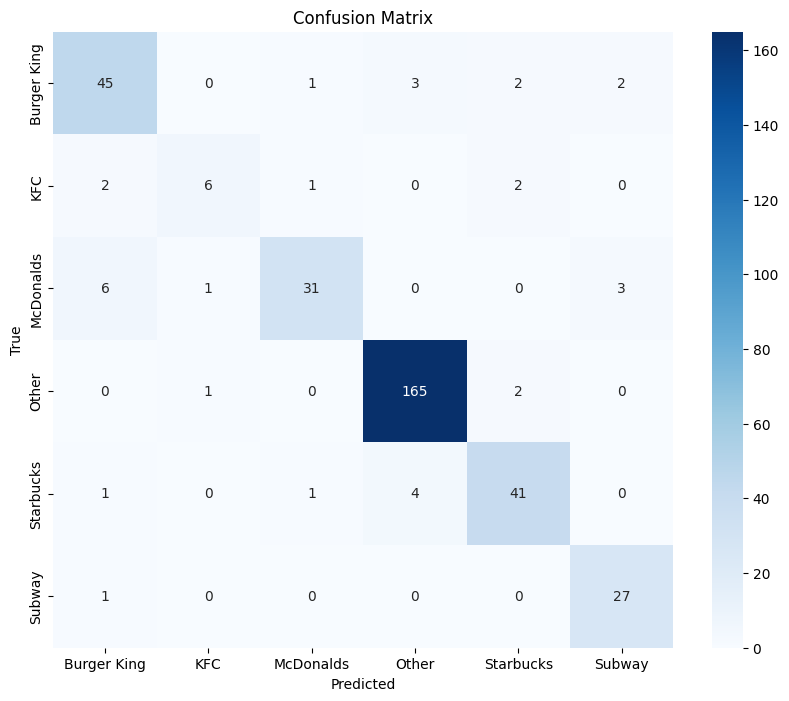


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.82      0.85      0.83        53
         KFC       0.75      0.55      0.63        11
   McDonalds       0.91      0.76      0.83        41
       Other       0.96      0.98      0.97       168
   Starbucks       0.87      0.87      0.87        47
      Subway       0.84      0.96      0.90        28

    accuracy                           0.91       348
   macro avg       0.86      0.83      0.84       348
weighted avg       0.90      0.91      0.90       348


--- Entrenando: 2. Base + SGD ---
[Epoch 1/15] Train Loss: 1.6308 | Train Acc: 41.22% | Val Loss: 1.4376 | Val Acc: 48.28%
[Epoch 2/15] Train Loss: 1.3031 | Train Acc: 54.10% | Val Loss: 1.1820 | Val Acc: 59.77%
[Epoch 3/15] Train Loss: 1.0941 | Train Acc: 60.58% | Val Loss: 0.9688 | Val Acc: 61.21%
[Epoch 4/15] Train Loss: 0.9526 | Train Acc: 63.67% | Val Loss: 0.8637 | Val Acc: 63.79%
[Epoch 5/15] Train Loss: 0.8399 

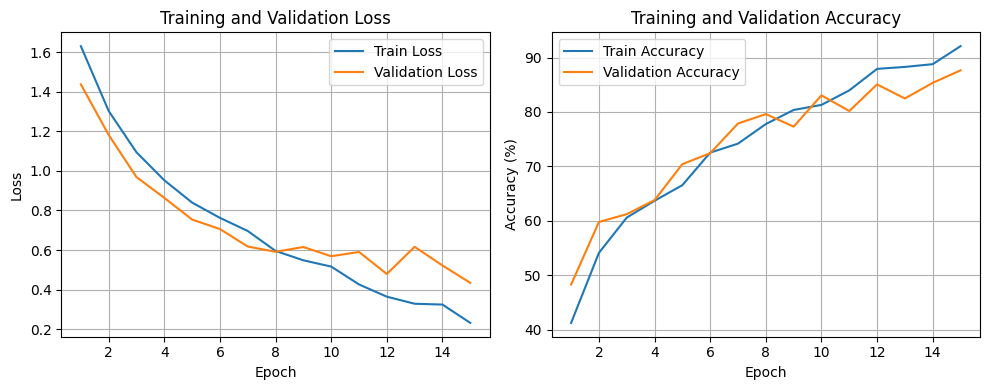

>> Matriz de Confusión (Modelo 2):


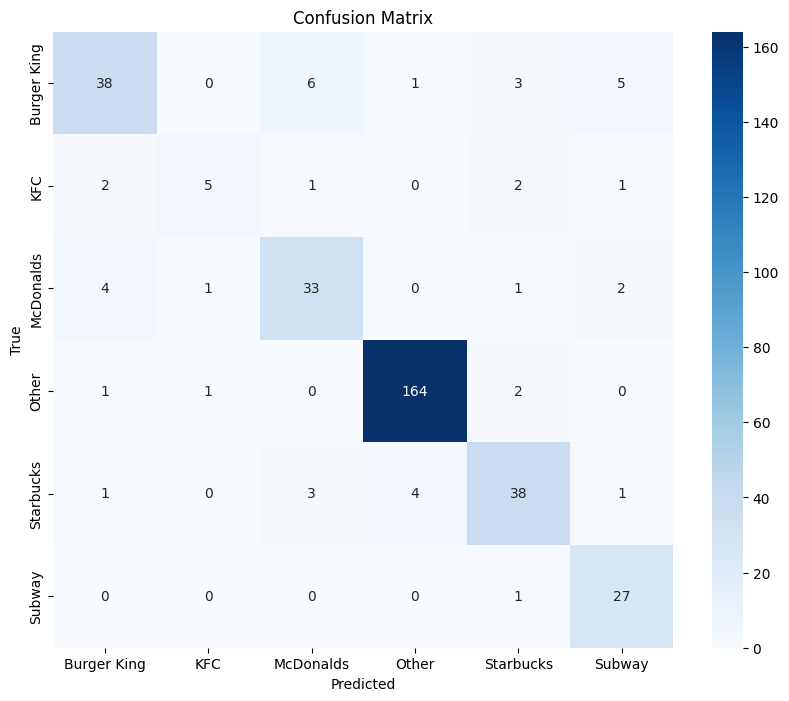


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.83      0.72      0.77        53
         KFC       0.71      0.45      0.56        11
   McDonalds       0.77      0.80      0.79        41
       Other       0.97      0.98      0.97       168
   Starbucks       0.81      0.81      0.81        47
      Subway       0.75      0.96      0.84        28

    accuracy                           0.88       348
   macro avg       0.81      0.79      0.79       348
weighted avg       0.88      0.88      0.87       348


--- Entrenando: 3. Dropout CNN ---
[Epoch 1/15] Train Loss: 1.2745 | Train Acc: 51.87% | Val Loss: 0.9056 | Val Acc: 65.80%
[Epoch 2/15] Train Loss: 0.8146 | Train Acc: 70.94% | Val Loss: 0.6578 | Val Acc: 76.72%
[Epoch 3/15] Train Loss: 0.6444 | Train Acc: 76.47% | Val Loss: 0.5727 | Val Acc: 79.89%
[Epoch 4/15] Train Loss: 0.5590 | Train Acc: 80.36% | Val Loss: 0.5134 | Val Acc: 82.76%
[Epoch 5/15] Train Loss: 0.4562

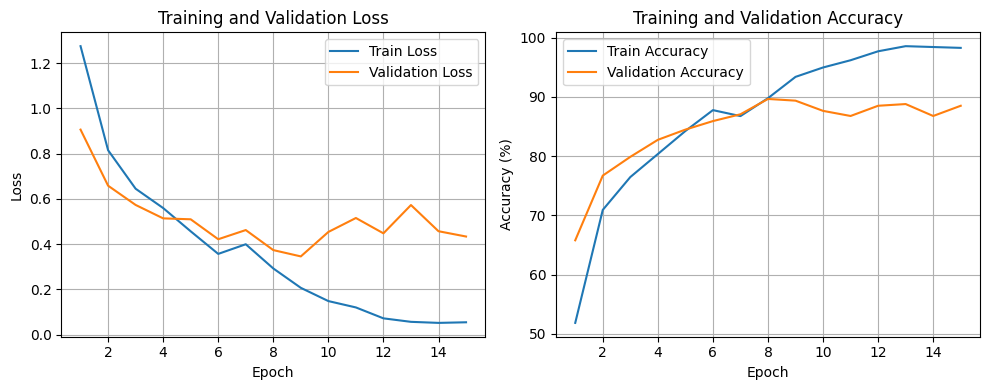

>> Matriz de Confusión (Modelo 3):


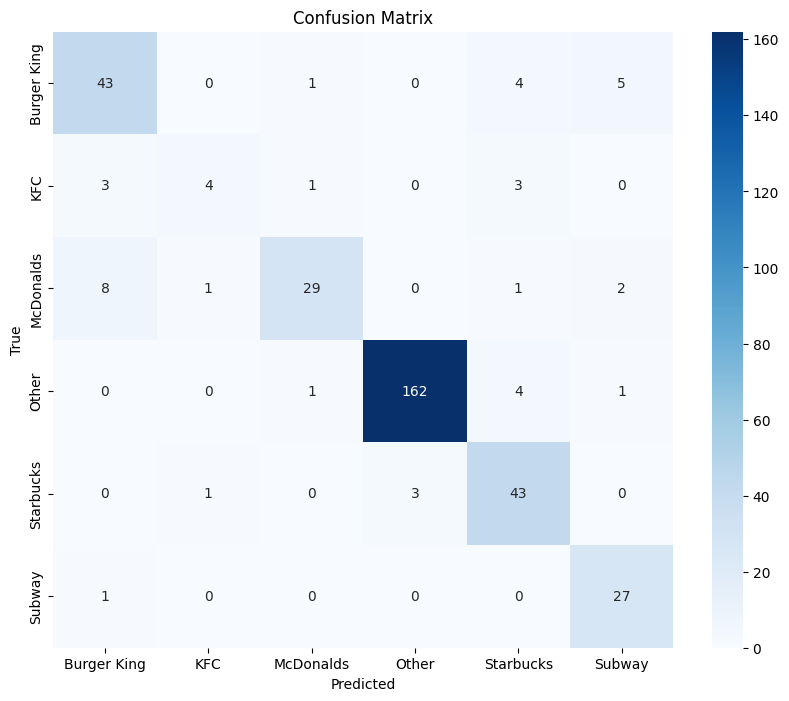


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.78      0.81      0.80        53
         KFC       0.67      0.36      0.47        11
   McDonalds       0.91      0.71      0.79        41
       Other       0.98      0.96      0.97       168
   Starbucks       0.78      0.91      0.84        47
      Subway       0.77      0.96      0.86        28

    accuracy                           0.89       348
   macro avg       0.81      0.79      0.79       348
weighted avg       0.89      0.89      0.88       348


--- Entrenando: 4. Deep CNN ---
[Epoch 1/25] Train Loss: 1.6033 | Train Acc: 47.27% | Val Loss: 1.4653 | Val Acc: 48.28%
[Epoch 2/25] Train Loss: 1.4083 | Train Acc: 47.27% | Val Loss: 1.2319 | Val Acc: 48.28%
[Epoch 3/25] Train Loss: 1.0824 | Train Acc: 55.90% | Val Loss: 0.8506 | Val Acc: 64.37%
[Epoch 4/25] Train Loss: 0.7981 | Train Acc: 69.71% | Val Loss: 0.6964 | Val Acc: 74.71%
[Epoch 5/25] Train Loss: 0.7018 | 

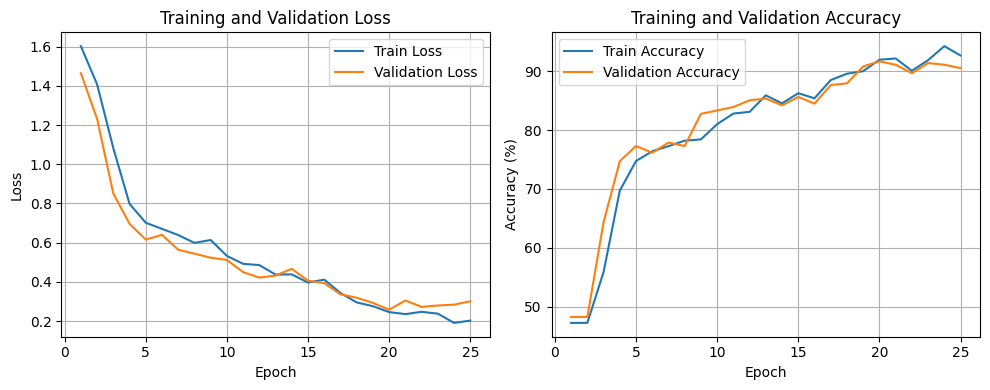

>> Matriz de Confusión (Modelo 4):


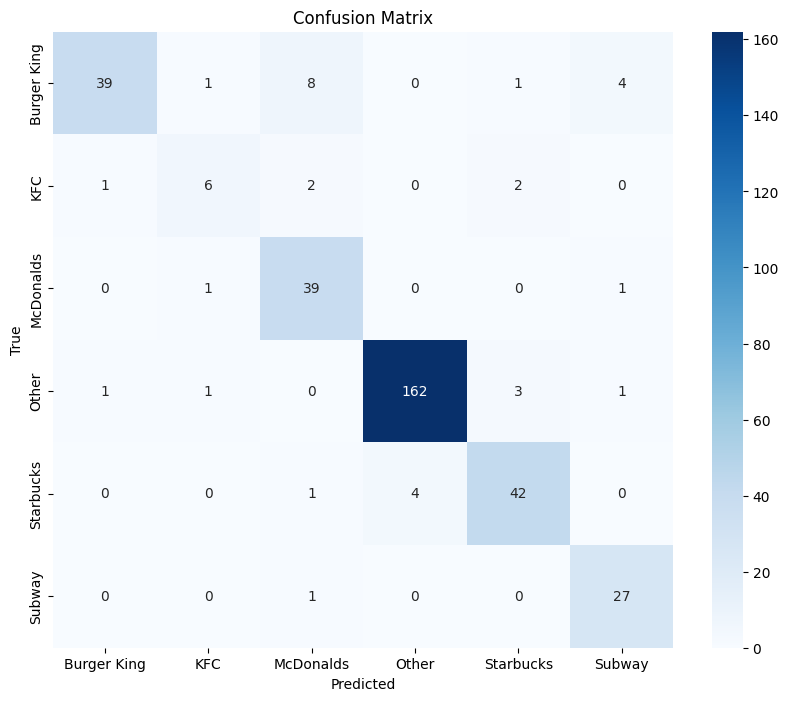


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.95      0.74      0.83        53
         KFC       0.67      0.55      0.60        11
   McDonalds       0.76      0.95      0.85        41
       Other       0.98      0.96      0.97       168
   Starbucks       0.88      0.89      0.88        47
      Subway       0.82      0.96      0.89        28

    accuracy                           0.91       348
   macro avg       0.84      0.84      0.84       348
weighted avg       0.91      0.91      0.90       348


--- Entrenando: 5. Data Augmentation ---
[Epoch 1/25] Train Loss: 1.3767 | Train Acc: 49.57% | Val Loss: 0.9869 | Val Acc: 66.09%
[Epoch 2/25] Train Loss: 0.9365 | Train Acc: 65.18% | Val Loss: 0.7902 | Val Acc: 72.70%
[Epoch 3/25] Train Loss: 0.7586 | Train Acc: 73.24% | Val Loss: 0.6302 | Val Acc: 76.44%
[Epoch 4/25] Train Loss: 0.6469 | Train Acc: 77.91% | Val Loss: 0.5408 | Val Acc: 82.18%
[Epoch 5/25] Train Loss: 

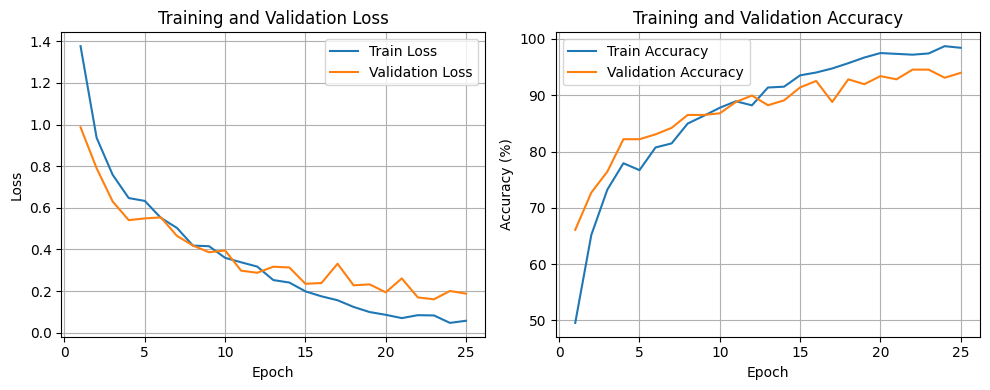

>> Matriz de Confusión (Modelo 5):


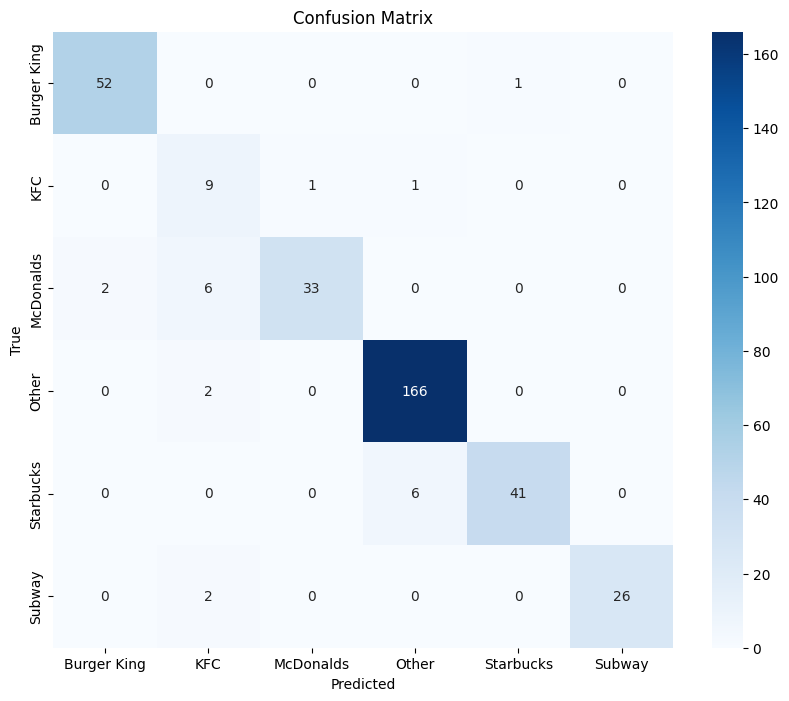


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.96      0.98      0.97        53
         KFC       0.47      0.82      0.60        11
   McDonalds       0.97      0.80      0.88        41
       Other       0.96      0.99      0.97       168
   Starbucks       0.98      0.87      0.92        47
      Subway       1.00      0.93      0.96        28

    accuracy                           0.94       348
   macro avg       0.89      0.90      0.88       348
weighted avg       0.95      0.94      0.94       348


--- COMPARATIVA DE ACCURACY (VALIDATION) ---
Base: 90.52%
SGD: 87.64%
Dropout: 88.51%
Deep: 90.52%
Augmentation: 93.97%


In [ ]:
# Contenedor para resultados finales
final_results = {}

# ==========================================
# EXPERIMENTO 1: MODELO BASE
# ==========================================
model1 = BaseCNN(num_classes).to(DEVICE)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# CORRECCIÓN: Desempaquetamos en 'model1' y 'h1'
model1, h1 = train_with_validation(
    model1,
    train_loader,
    val_loader,
    criterion,
    optimizer1,
    epochs=15,
    name="1. Base CNN"
)

plot_training_history(h1)
print(">> Matriz de Confusión (Modelo 1):")
plot_confusion_matrix(model1, val_loader, class_names, DEVICE)
# CORRECCIÓN: Usamos 'dev_acc' que es la clave que usa tu función
final_results['Base'] = h1['dev_acc'][-1]



# ==========================================
# EXPERIMENTO 2: LEARNING RATE BAJO (SGD)
# ==========================================
model2 = BaseCNN(num_classes).to(DEVICE)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

model2, h2 = train_with_validation(
    model2,
    train_loader,
    val_loader,
    criterion,
    optimizer2,
    epochs=15,
    name="2. Base + SGD"
)

plot_training_history(h2)
print(">> Matriz de Confusión (Modelo 2):")
plot_confusion_matrix(model2, val_loader, class_names, DEVICE)
final_results['SGD'] = h2['dev_acc'][-1]

# ==========================================
# EXPERIMENTO 3: DROPOUT
# ==========================================
model3 = DropoutCNN(num_classes).to(DEVICE)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

model3, h3 = train_with_validation(
    model3,
    train_loader,
    val_loader,
    criterion,
    optimizer3,
    epochs=15,
    name="3. Dropout CNN"
)

plot_training_history(h3)
print(">> Matriz de Confusión (Modelo 3):")
plot_confusion_matrix(model3, val_loader, class_names, DEVICE)
final_results['Dropout'] = h3['dev_acc'][-1]

# ==========================================
# EXPERIMENTO 4: RED PROFUNDA
# ==========================================
model4 = DeepCNN(num_classes).to(DEVICE)
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)

model4, h4 = train_with_validation(
    model4,
    train_loader,
    val_loader,
    criterion,
    optimizer4,
    epochs=25,
    name="4. Deep CNN"
)

plot_training_history(h4)
print(">> Matriz de Confusión (Modelo 4):")
plot_confusion_matrix(model4, val_loader, class_names, DEVICE)
final_results['Deep'] = h4['dev_acc'][-1]

# ==========================================
# EXPERIMENTO 5: DATA AUGMENTATION
# ==========================================
# Asegúrate de haber definido 'transform_aug' y recargado estos datos antes
# Si no lo has hecho, usa los loaders normales para probar

transform_aug = transforms.Compose([
    transforms.Resize((64, 64)),          # Tamaño base
    transforms.RandomHorizontalFlip(),    # Volteo horizontal aleatorio
    transforms.RandomRotation(15),        # Rotación leve (±15 grados)
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Variación de brillo/contraste
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
aug_dataset_full = datasets.ImageFolder(root=train_data_dir, transform=transform_aug)
aug_train_subset = torch.utils.data.Subset(aug_dataset_full, train_dataset.indices)
aug_train_loader = DataLoader(aug_train_subset, batch_size=64, shuffle=True)

model5 = BaseCNN(num_classes).to(DEVICE)
optimizer5 = optim.Adam(model5.parameters(), lr=0.001)

# Nota: Aquí asumo que tienes un 'aug_train_loader' definido.
# Si no, usa 'train_loader' normal.
model5, h5 = train_with_validation(
    model5,
    aug_train_loader, # Cambia esto por aug_train_loader si hiciste el paso de Data Augmentation
    val_loader,
    criterion,
    optimizer5,
    epochs=25,
    name="5. Data Augmentation"
)

plot_training_history(h5)
print(">> Matriz de Confusión (Modelo 5):")
plot_confusion_matrix(model5, val_loader, class_names, DEVICE)
final_results['Augmentation'] = h5['dev_acc'][-1]

# --- RESUMEN FINAL ---
print("\n--- COMPARATIVA DE ACCURACY (VALIDATION) ---")
for name, acc in final_results.items():
    print(f"{name}: {acc:.2f}%")


--- EVALUACIÓN FINAL EN TEST SET ---
Accuracy Final en Test: 54.29%
Detalle por clases (Test Set):


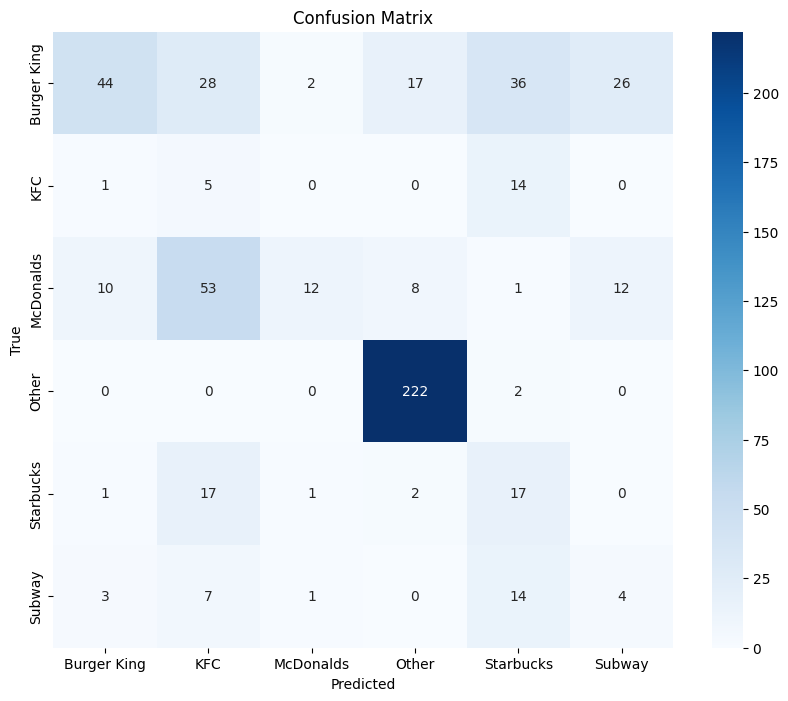


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.75      0.29      0.42       153
         KFC       0.05      0.25      0.08        20
   McDonalds       0.75      0.12      0.21        96
       Other       0.89      0.99      0.94       224
   Starbucks       0.20      0.45      0.28        38
      Subway       0.10      0.14      0.11        29

    accuracy                           0.54       560
   macro avg       0.46      0.37      0.34       560
weighted avg       0.71      0.54      0.55       560



In [ ]:
print("\n--- EVALUACIÓN FINAL EN TEST SET ---")
# Solo lo hacemos con el modelo ganador
best_model = model5

# 1. Calcular precisión exacta en Test
correct = 0
total = 0
best_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Accuracy Final en Test: {test_acc:.2f}%")

# 2. Matriz de confusión real del Test
print("Detalle por clases (Test Set):")
plot_confusion_matrix(best_model, test_loader, class_names, DEVICE)

TransferLearning

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]



--- Entrenando: 6. Transfer Learning ---
[Epoch 1/5] Train Loss: 0.9008 | Train Acc: 68.20% | Val Loss: 0.4781 | Val Acc: 85.34%
[Epoch 2/5] Train Loss: 0.4600 | Train Acc: 83.88% | Val Loss: 0.2834 | Val Acc: 93.68%
[Epoch 3/5] Train Loss: 0.2674 | Train Acc: 91.22% | Val Loss: 0.2081 | Val Acc: 94.54%
[Epoch 4/5] Train Loss: 0.1791 | Train Acc: 95.18% | Val Loss: 0.1413 | Val Acc: 95.40%
[Epoch 5/5] Train Loss: 0.1407 | Train Acc: 95.54% | Val Loss: 0.1260 | Val Acc: 96.55%


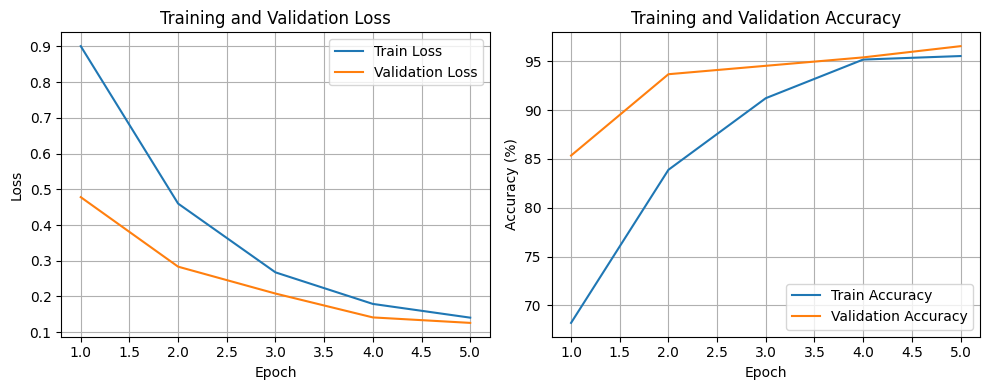


>> Matriz de Confusión (Transfer Learning):


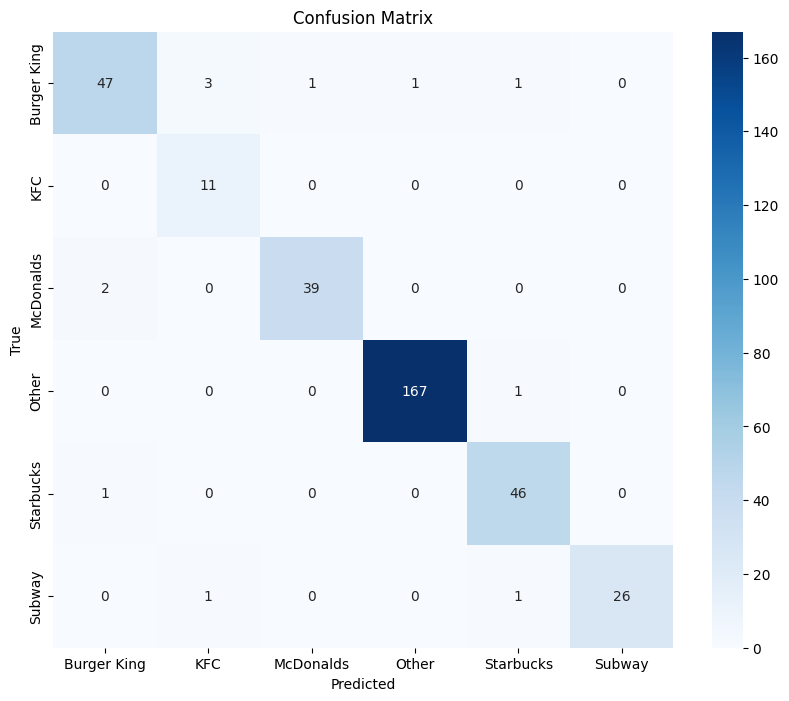


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.94      0.89      0.91        53
         KFC       0.73      1.00      0.85        11
   McDonalds       0.97      0.95      0.96        41
       Other       0.99      0.99      0.99       168
   Starbucks       0.94      0.98      0.96        47
      Subway       1.00      0.93      0.96        28

    accuracy                           0.97       348
   macro avg       0.93      0.96      0.94       348
weighted avg       0.97      0.97      0.97       348



In [ ]:
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Recargamos dataset solo para este experimento
tl_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform_resnet)

# Usamos los mismos índices para mantener la consistencia en la división
tl_train_subset = torch.utils.data.Subset(tl_dataset, train_dataset.indices)
tl_val_subset = torch.utils.data.Subset(tl_dataset, val_dataset.indices)

# Nuevos Loaders (Batch size más pequeño si te da error de memoria, e.g., 32)
tl_train_loader = DataLoader(tl_train_subset, batch_size=32, shuffle=True)
tl_val_loader = DataLoader(tl_val_subset, batch_size=32, shuffle=False)
# Cargar preentrenado
model_tl = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar capas (Feature Extractor)
for param in model_tl.parameters():
    param.requires_grad = False

# Reemplazar la cabeza (Fully Connected)
# ResNet18 tiene 512 neuronas antes de la capa final
model_tl.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes) # 6 clases
)

model_tl = model_tl.to(DEVICE)

# Optimizador (Solo entrenamos la capa final 'fc', es más rápido)
criterion = nn.CrossEntropyLoss()
optimizer_tl = optim.Adam(model_tl.fc.parameters(), lr=0.001)


# --- 3. ENTRENAMIENTO ---
# Reutilizamos tu función train_with_validation
model_tl, h_tl = train_with_validation(
    model_tl,
    tl_train_loader,
    tl_val_loader,
    criterion,
    optimizer_tl,
    epochs=5,  # Suele converger muy rápido, 5 épocas suelen bastar
    name="6. Transfer Learning"
)


# --- 4. RESULTADOS ---
plot_training_history(h_tl)

print("\n>> Matriz de Confusión (Transfer Learning):")
plot_confusion_matrix(model_tl, tl_val_loader, class_names, DEVICE)

# Guardar resultado en el diccionario global
final_results['Transfer Learning'] = h_tl['dev_acc'][-1]